# Финальный проект. Вариант 1

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep =';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep =';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проведем разведовательный анализ данных перед выполнением основного задания.

In [4]:
reg_data.shape # Проверим размеры датафреймов

(1000000, 2)

In [5]:
auth_data.shape

(9601013, 2)

In [6]:
reg_data.uid.nunique() # Обе таблицы имеют столбец с id игроков, проверим, сколько уникальных значений в каждой таблице

1000000

In [7]:
auth_data.uid.nunique()

1000000

In [8]:
reg_data.info() # Проверим, нет ли пропущенных значений в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [9]:
auth_data.dtypes # Посмотрим типы данных

auth_ts    int64
uid        int64
dtype: object

In [10]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

Так как столбцы "reg_ts" и "auth_ts" содержат информацию о времени, но в непривычном (менее наглядном) формате UNIX time, сконвертируем их в human-readable формат.

In [11]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')

In [12]:
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [13]:
reg_data.dtypes # Проверим, формат поменялся

reg_ts    datetime64[ns]
uid                int64
dtype: object

Согласно заданию, нам необходимо посчитать retention игроков (по дням от даты регистрации игрока). Часто retention rate считают для временных когорт, объединяют пользователей во временному признаку. В нашем случае мы так и поступим, объединим игроков по дате регистрации и посчитаем retention rate для каждой когорты. Когорты будем строить по месяцам, так как у нас большой временной диапозон:

In [14]:
reg_data.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [15]:
reg_data.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

In [16]:
reg_data['reg_ts'] = reg_data['reg_ts'].astype('datetime64[M]') # Переведем даты в формат месяца - первое число месяца

In [17]:
reg_data.head()

,reg_ts,uid
0,1998-11-01,1
1,1999-07-01,2
2,2000-01-01,3
3,2000-05-01,4
4,2000-09-01,5


In [18]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s') # Произведем такие же операции со столбцом второго датафрейма

In [19]:
auth_data['auth_ts'] = auth_data['auth_ts'].astype('datetime64[M]')

In [20]:
auth_data.head()

,auth_ts,uid
0,1998-11-01,1
1,1999-07-01,2
2,1999-07-01,2
3,1999-07-01,2
4,1999-08-01,2


In [21]:
all_data_users = reg_data.merge(auth_data, on = 'uid') # Объединим два датафрейма для дальнейшего анализа

In [22]:
all_data_users.shape # Проверяем, не потеряли ли мы строки

(9601013, 3)

Сейчас сгруппируем данные по дате регистрации и дате авторизации, и посчитаем уникальные значения пользователей на конец периода для расчета показателя retention.

In [23]:
all_data_users = all_data_users.groupby(['reg_ts', 'auth_ts'], as_index = False).uid.nunique().rename(columns = {'uid':'cohort_users'})

In [24]:
all_data_users

,reg_ts,auth_ts,cohort_users
0,1998-11-01,1998-11-01,1
1,1999-07-01,1999-07-01,1
2,1999-07-01,1999-08-01,1
3,1999-07-01,1999-09-01,1
4,1999-07-01,1999-10-01,1
...,...,...,...
13755,2020-07-01,2020-08-01,7958
13756,2020-07-01,2020-09-01,2751
13757,2020-08-01,2020-08-01,47882
13758,2020-08-01,2020-09-01,8389


Посчитаем число ункальных пользователей для наших когорт (месяцев).

In [25]:
cohorts = reg_data.groupby('reg_ts', as_index = False).uid.nunique().rename(columns = {'uid':'initial_users'})

In [26]:
cohorts.shape

(235, 2)

In [27]:
cohorts.initial_users.sum() # Проверка пользователей, никого ли мы не потеряли

1000000

In [28]:
all_data_users = all_data_users.merge(cohorts, on = 'reg_ts') # Добавим столбец с первоначальним числом пользователей в общий датафрейм

In [29]:
all_data_users

,reg_ts,auth_ts,cohort_users,initial_users
0,1998-11-01,1998-11-01,1,1
1,1999-07-01,1999-07-01,1,1
2,1999-07-01,1999-08-01,1,1
3,1999-07-01,1999-09-01,1,1
4,1999-07-01,1999-10-01,1,1
...,...,...,...,...
13755,2020-07-01,2020-08-01,7958,45502
13756,2020-07-01,2020-09-01,2751,45502
13757,2020-08-01,2020-08-01,47882,47882
13758,2020-08-01,2020-09-01,8389,47882


In [30]:
all_data_users['cohort_diff'] = all_data_users.auth_ts - all_data_users.reg_ts # Посчитаем разницу в днях между датой регистрации и авторизацией

In [31]:
all_data_users.head()

,reg_ts,auth_ts,cohort_users,initial_users,cohort_diff
0,1998-11-01,1998-11-01,1,1,0 days
1,1999-07-01,1999-07-01,1,1,0 days
2,1999-07-01,1999-08-01,1,1,31 days
3,1999-07-01,1999-09-01,1,1,62 days
4,1999-07-01,1999-10-01,1,1,92 days


In [32]:
all_data_users['retention'] = all_data_users.cohort_users / all_data_users.initial_users # Посчитаем Retention Rate

In [33]:
all_data_users['retention_month'] = (all_data_users['cohort_diff']/np.timedelta64(1, 'M') + 1).round()

In [35]:
all_data_users.head()

,reg_ts,auth_ts,cohort_users,initial_users,cohort_diff,retention,retention_month
0,1998-11-01,1998-11-01,1,1,0 days,1.0,1.0
1,1999-07-01,1999-07-01,1,1,0 days,1.0,1.0
2,1999-07-01,1999-08-01,1,1,31 days,1.0,2.0
3,1999-07-01,1999-09-01,1,1,62 days,1.0,3.0
4,1999-07-01,1999-10-01,1,1,92 days,1.0,4.0


Данные мы подготовили, далее можем рассматривать те промежутки времени, которые нас интересуют. Создадим переменную period, в которой можно задавать период дат регистрации (reg_ts) и количество месяцев (retention_month) с месяца регистрации.

In [36]:
#period = "reg_ts >= '1998-11-01' and reg_ts <= '2020-09-01'" # Максимальный период данных

In [37]:
period = "reg_ts >= '2019-01-01' and reg_ts <= '2019-12-01' and retention_month >= 1 and retention_month <= 12" # Для примера

In [38]:
all_data_users.query(period).head(10) # Проверим, какие данные выводятся в таблицу

,reg_ts,auth_ts,cohort_users,initial_users,cohort_diff,retention,retention_month
13529,2019-01-01,2019-01-01,18510,18510,0 days,1.000000,1.0
13530,2019-01-01,2019-02-01,3284,18510,31 days,0.177418,2.0
13531,2019-01-01,2019-03-01,1240,18510,59 days,0.066991,3.0
13532,2019-01-01,2019-04-01,945,18510,90 days,0.051053,4.0
13533,2019-01-01,2019-05-01,945,18510,120 days,0.051053,5.0
13534,2019-01-01,2019-06-01,945,18510,151 days,0.051053,6.0
13535,2019-01-01,2019-07-01,945,18510,181 days,0.051053,7.0
13536,2019-01-01,2019-08-01,945,18510,212 days,0.051053,8.0
13537,2019-01-01,2019-09-01,945,18510,243 days,0.051053,9.0
13538,2019-01-01,2019-10-01,945,18510,273 days,0.051053,10.0


In [39]:
retention_pivot = all_data_users.query(period).pivot_table(index='reg_ts',
                                      columns='retention_month',
                                      values='retention',
                                      aggfunc='sum')

In [40]:
retention_pivot

retention_month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
reg_ts,,,,,,,,,,,,
2019-01-01,1.0,0.177418,0.066991,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053
2019-02-01,1.0,0.183372,0.063138,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684
2019-03-01,1.0,0.172975,0.059914,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539
2019-04-01,1.0,0.174778,0.062548,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838
2019-05-01,1.0,0.174738,0.061957,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805
2019-06-01,1.0,0.179888,0.063246,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914
2019-07-01,1.0,0.172912,0.061783,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510
2019-08-01,1.0,0.171064,0.061151,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342
2019-09-01,1.0,0.174042,0.062835,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107


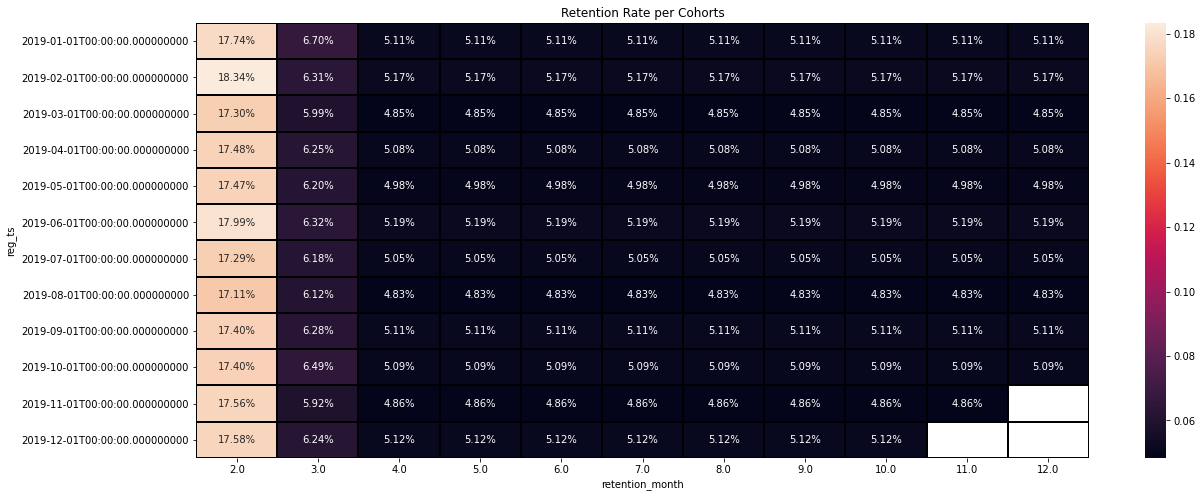

In [41]:
plt.figure(figsize=(20, 8))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='black')

Мы рассмотрели детально, как расчитывается retention для когорт по месяцам регистрации, теперь давайте составим универсальную формулу, которая будет включать все шаги, которые мы прошли ранее.

#### Формула для расчета Retention Rate по когортам - месяцам:

In [42]:
reg_data_to_function = '~/shared/problem1-reg_data.csv'

In [43]:
auth_data_to_function = '~/shared/problem1-auth_data.csv'

In [44]:
#period = "reg_ts >= '1998-11-01' and reg_ts <= '2020-09-01'" # Максимальный период данных

In [45]:
period = "reg_ts >= '2019-01-01' and reg_ts <= '2019-12-01' and retention_month >= 1 and retention_month <= 12" # Для примера

In [46]:
def retention_function(reg_data_to_function, auth_data_to_function):
    '''
    Возвращает Retention Rate в формате таблицы и тепловой карты.
            Параметры:
                    reg_data_to_function: путь к данным с информацией о датах регистрации пользователей
                    auth_data_to_function: путь к данным с информацией о датах авторизации пользователей
            Возвращаемое значение:
                    Retention Rate в формате таблицы и тепловой карты
    '''
    get_data_reg = pd.read_csv(reg_data_to_function, sep =';')
    get_data_auth = pd.read_csv(auth_data_to_function, sep =';')
    get_data_reg['reg_ts'] = pd.to_datetime(get_data_reg['reg_ts'], unit='s')
    get_data_reg['reg_ts'] = get_data_reg['reg_ts'].astype('datetime64[M]')
    get_data_auth['auth_ts'] = pd.to_datetime(get_data_auth['auth_ts'], unit='s')
    get_data_auth['auth_ts'] = get_data_auth['auth_ts'].astype('datetime64[M]')
    all_data_users = reg_data.merge(auth_data, on = 'uid')
    all_data_users = all_data_users.groupby(['reg_ts', 'auth_ts'], as_index = False).uid.nunique().rename(columns = {'uid':'cohort_users'})
    cohorts = reg_data.groupby('reg_ts', as_index = False).uid.nunique().rename(columns = {'uid':'initial_users'})
    all_data_users = all_data_users.merge(cohorts, on = 'reg_ts')
    all_data_users['cohort_diff'] = all_data_users.auth_ts - all_data_users.reg_ts
    all_data_users['retention'] = all_data_users.cohort_users / all_data_users.initial_users
    all_data_users['retention_month'] = (all_data_users['cohort_diff']/np.timedelta64(1, 'M') + 1).round()
    retention_pivot = all_data_users.query(period).pivot_table(index='reg_ts', columns='retention_month', values='retention', aggfunc='sum')
    plt.figure(figsize=(20, 8))
    plt.title('Retention Rate per Cohorts')
    sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='black')
    return (retention_pivot)

In [47]:
print(retention_function.__doc__)


    Возвращает Retention Rate в формате таблицы и тепловой карты.
            Параметры:
                    reg_data_to_function: путь к данным с информацией о датах регистрации пользователей
                    auth_data_to_function: путь к данным с информацией о датах авторизации пользователей
            Возвращаемое значение:
                    Retention Rate в формате таблицы и тепловой карты
    


retention_month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
reg_ts,,,,,,,,,,,,
2019-01-01,1.0,0.177418,0.066991,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053,0.051053
2019-02-01,1.0,0.183372,0.063138,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684,0.051684
2019-03-01,1.0,0.172975,0.059914,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539,0.048539
2019-04-01,1.0,0.174778,0.062548,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838,0.050838
2019-05-01,1.0,0.174738,0.061957,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805,0.049805
2019-06-01,1.0,0.179888,0.063246,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914,0.051914
2019-07-01,1.0,0.172912,0.061783,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510,0.050510
2019-08-01,1.0,0.171064,0.061151,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342,0.048342
2019-09-01,1.0,0.174042,0.062835,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107,0.051107


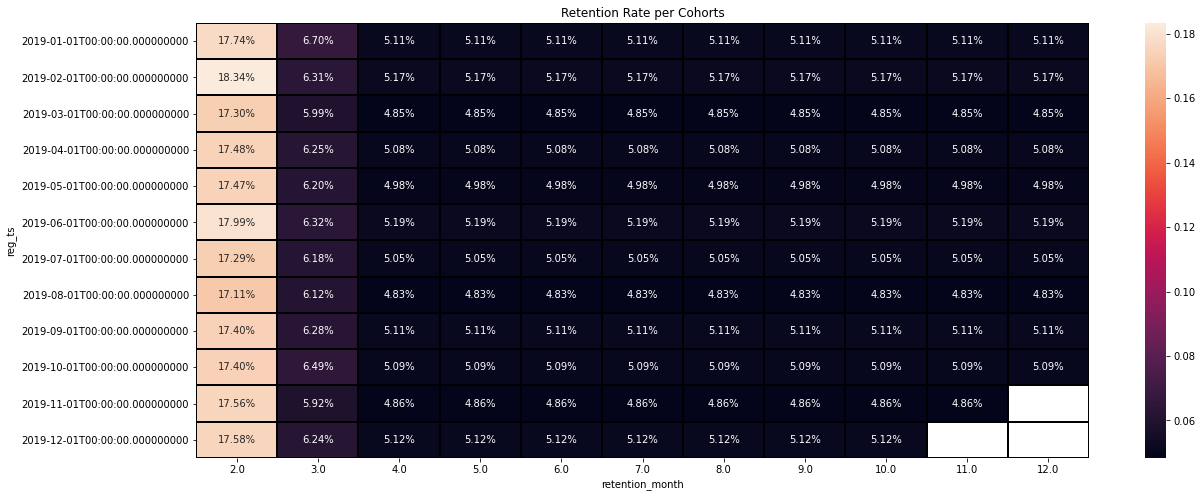

In [48]:
retention_function(reg_data_to_function, auth_data_to_function)

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для принятия решения о том, какое предложение можно считать лучшим, мы посчитаем три продуктовые метрики (ARPU, ARPPU, CR) для каждой группы, сравним их и проверим, есть ли статистически значимые различия.

Начнем с загрузки данных и разведовательного анализа.

In [49]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-murzakova/final_project_own/variant_1/Проект_1_Задание_2.csv', sep = ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [50]:
df.shape

(404770, 3)

In [51]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


#### ARPU
Начнем с первой метрики - ARPU. Метрика ARPU отвечает на вопрос: сколько выручки приносит средний активный пользователь за изучаемый период времени. В задании сказано, что ARPU в тестовой группе выше на 5%, чем в контрольной, также проверим данную информацию. За активных пользователей будем считать всех пользователей: и платящих, и тех, по кому пока не было получено выручки.

In [52]:
ARPU_a = df.query("testgroup == 'a'").revenue.sum() / df.query("testgroup == 'a'").user_id.count() # Посчитаем показатели "внучную"
ARPU_a

25.413719736965806

In [53]:
ARPU_b = df.query("testgroup == 'b'").revenue.sum() / df.query("testgroup == 'b'").user_id.count()
ARPU_b

26.75128659327863

In [54]:
np.round(ARPU_a / ARPU_b, 2)

0.95

Действительно, ARPU в контрольной группе ниже на 5%, чем в тестовой. Посмотрим данные более детально.

In [55]:
df.groupby('testgroup', as_index=False).agg({'user_id':'count'}) # Количество пользователей в каждой группе почти не отличается

,testgroup,user_id
0,a,202103
1,b,202667


In [56]:
df.groupby('testgroup', as_index=False).agg({'revenue':'sum'}) # Сумма выручки по каждой группе, в группе "b" выше почти на 300k

,testgroup,revenue
0,a,5136189
1,b,5421603


In [57]:
df.groupby('testgroup', as_index = False).revenue.mean().round(2) # Среднее значение выручки для всех игроков каждой группы

,testgroup,revenue
0,a,25.41
1,b,26.75


Мы видим, что ARPU второго предложения выше, чем в первой группе, сразу хочется сделать вывод о том, что второй набор предложений (b) лучше себя показал, но для того, чтобы сделать выводы о лучшей версии предложения, необходимо полагаться на статистические данные.

Для выбора теста для проверки статистической значимости сперва посмотрим на распределение данных.

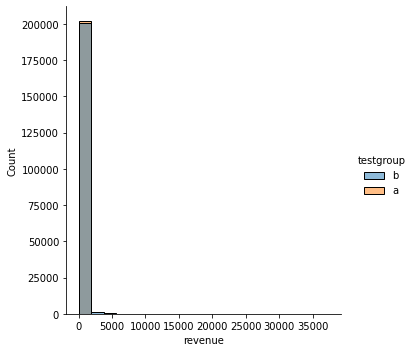

In [58]:
sns.displot(data = df, x = 'revenue', hue = 'testgroup')

Построив гистограмму, видим, что распределение сильно сдвинуто влево, сконцентрировано вместе, то есть распределение далекое от нормального. Давайте это проверим с помощью теста Шапиро Уилко.

In [59]:
a_group = df.query("testgroup == 'a'").revenue # Выручка по группам
b_group = df.query("testgroup == 'b'").revenue

In [60]:
stats.shapiro(a_group) # Проверим распределение на нормальность с помощью теста Шапиро_Уилко

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [61]:
stats.shapiro(b_group)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

Так как нулевая гипотеза в случае Шапиро-Уилка — нормальность распределения, то здесь мы можем сделать вывод о том, что распределение отклоняется от нормального (p-value < 0.05, отклоняем нулевую гипотезу о том, что распределение нормальное).

В данном случае у нас много нулевых значений (неплатящие игроки), поэтому проводить тест Манна Уитни и трансформировать распределение (логарифмировать) мы не будем.

Так как выборки большого размера (больше 30), проверим гипотезы с помощью t-test.

* H0 (нулевая гипотеза) - средние значения значимо не различаются
* H1 (альтернативная гипотеза) - средние значения значимо различаются

In [62]:
stats.ttest_ind(a_group, b_group)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

P-value больше 0.05, поэтому мы не можем отклонить нулевую гипотезу и сделать вывод о том, что одно предложение лучше другого. Таким образом, мы не можем полагаться на метрику ARPU для принятия решения о лучшем предложении, давайте проанализируем другие метрики.

#### ARPPU
Метрика ARPPU отвечает на вопрос: сколько выручки приносит средний платящий пользователь за изучаемый период времени.

In [63]:
ARPPU_a = df.query("testgroup == 'a'").revenue.sum() / df.query("testgroup == 'a' and revenue != 0").user_id.count()
ARPPU_a

2663.9984439834025

In [64]:
ARPPU_b = df.query("testgroup == 'b'").revenue.sum() / df.query("testgroup == 'b' and revenue != 0").user_id.count()
ARPPU_b

3003.6581717451522

In [65]:
np.round(ARPPU_a / ARPPU_b, 2)

0.89

In [66]:
df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id':'count'}) # Количество платящих пользователей в каждой группе

,testgroup,user_id
0,a,1928
1,b,1805


In [67]:
df.query('revenue != 0').groupby('testgroup', as_index = False).revenue.mean().round(2) # Среднее значение выручки у платящих игроков

,testgroup,revenue
0,a,2664.00
1,b,3003.66


Количество платящих игроков во второй группе меньше, однако, среднее значение выручки больше, также мы помним, что общее значение выручки во второй группе выше.

Проверим распределение в данных группах и применим тесты для проверки статистической значимости.

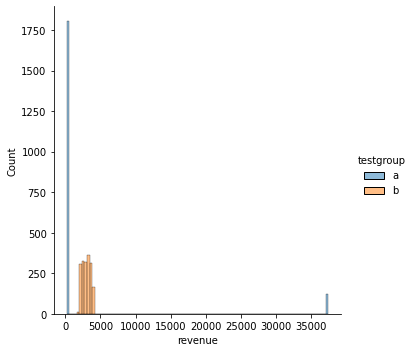

In [68]:
sns.displot(data = df.query('revenue != 0'), x = 'revenue', hue = 'testgroup')

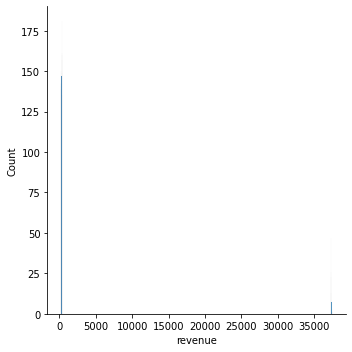

In [69]:
sns.displot(data = df.query("revenue != 0 and testgroup == 'a'"), x = 'revenue')

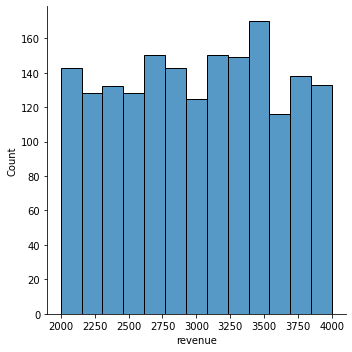

In [70]:
sns.displot(data = df.query("revenue != 0 and testgroup == 'b'"), x = 'revenue')

In [71]:
a_group_pay = df.query("testgroup == 'a' and revenue != 0").revenue # Выручки по группам и платящим игрокам
b_group_pay = df.query("testgroup == 'b' and revenue != 0").revenue

In [72]:
stats.shapiro(a_group_pay) # Проверка нормальности распределения

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [73]:
stats.shapiro(b_group_pay) # p-value > 0,05, значит не отклоняем нулевую гипотезу о нормальности распределения

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

Тест Шапиро Уилка показал, что распределение данных группы "a" снова далеко от нормального, так как p-value < 0.05, отклоняем нулевую гипотезу о том, что распределение нормальное. Попробуем прологорифмировать значения, чтобы приблизить их к нормальному распределению.

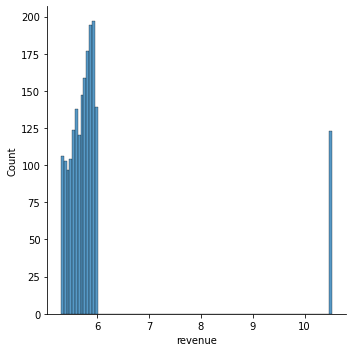

In [74]:
sns.displot(np.log(a_group_pay))

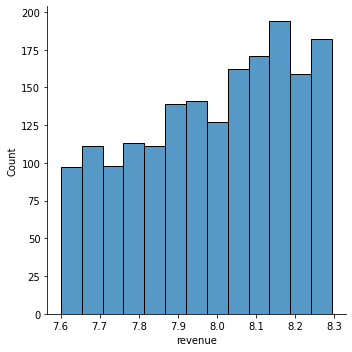

In [75]:
sns.displot(np.log(b_group_pay))

Логарифмирование не помогло нам приблизиться к желаемому результату (нормальному распределению), поэтому предлагаю воспользоваться методом bootstrap.

In [76]:
bootstrap((a_group_pay, ), np.mean, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=2261.590015560166, high=3086.698703319502), standard_error=209.03809846460047)

In [77]:
bootstrap((b_group_pay, ), np.mean, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=2976.7573407202212, high=3029.793767313019), standard_error=13.50678616138945)

Метод bootstrap сформировал доверительные интервалы для средних значений, и мы видим, что полученные границы пересекаются, что говорит о том, на основании данной метрики мы не можем сделать вывод о лучшем предложении.

#### CR
Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие (заплатили) к общему числу пользователей.

In [78]:
CR_a = np.round(df.query("testgroup == 'a' and revenue != 0").user_id.count() / df.query("testgroup == 'a'").user_id.count(), 4)
CR_a

0.0095

In [79]:
CR_b = np.round(df.query("testgroup == 'b' and revenue != 0").user_id.count() / df.query("testgroup == 'b'").user_id.count(), 4)
CR_b

0.0089

Мы видим, что конверсия в покупку второй группы "b" ниже, но давайте проверим, есть ли взаимосвязь между группами и платящими пользователями. Для это поменяем данные о выручке на категориальные переменные (0 - нет выручки или выручка равна нулю, 1 - есть выручка в любом размере, то есть пользователь платящий).
На основе данных мы построим таблицу сопряженности и попробуем её проанализировать.
В качестве метрики будем считать количество плательщиков.

In [80]:
df['revenue_range'] = np.where(df.revenue == 0, 0, 1) # Приведем данные по выручке в категориальный вид
df.head()

,user_id,revenue,testgroup,revenue_range
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [81]:
cr = pd.crosstab(df.testgroup, df.revenue_range) # Составим таблицу сопряженности
cr

revenue_range,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [82]:
chi2_contingency(cr) # Проверим взаимосвязь между группами и платящими пользовятелями с помощью теста хи-квадрат

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

Значение p-value меньше 5%, значит можем отвергнуть гипотезу Н0 о том, что взаимосвязи между группами и количеством платящих пользователей не существует.

### Итого:

Результат исследования показал, что на основании мертрик ARPU и ARPPU мы не можем сделать вывод о лучшем предложении, так как анализ данных не показал статистически значимые различия.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Вопрос 1: С помощью каких метрик можно оценить результаты последнего прошедшего события?

1. Для оценки прошедшего события можно оценить аудиторию, принимавшую участие, как она менялась от события к событию:
    * DAU - количество уникальных пользователей, которые зашли в приложение в течение суток или средняя дневная аудитория (если события имеют разную продолжительность);
    * Доля новых пользователей — отношение числа новых пользователей за какой-то промежуток времени ко всем пользователям за этот же промежуток времени;
    * Количество авторизаций (всего).

Все данные метрики анализа аудитории можем сравнить с предыдущими мероприятиями.

2. Далее можем проанализировать сами сессии участников:
    * Среднее время сессий в событии;
    * Количество игроков, которым удалось пройти все уровни (абсолютная конверсия) и частично уровни (относительная конверсия). 
    На каком этапе воронки относительная конверсия самая высокая / самая низкая и почему.
    * Конверсионное окно — время, за которое игрок переходит из одного шага воронки в другой (перемещается между уровнями).

#### Вопрос 2: Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

После проведения мероприятия с изменением правил игры, последовательности действий, будет интересно посмотреть число новых/отвалившихся/вернувшихся пользователей. Также будет полезно в далнейшем сравнить с результатами будущего сеанса, захотят ли игроки участвовать повторно (retention - удержание).

Как и в предыдущем вопросе, необходимо проанализировать все перечисленные метрики, добавятся дополнительные показатели конверсии, так как увеличивается количество шагов. Казалось бы, время сессии должно увеличиться, так как время прохождения уровней увеличится, но это только наши ожидания, необходимо анализировать реальные данные и смотреть, есть ли статистически значимая взаимосвязь между этими событиями.